In [1]:
%pylab inline
import sys
import pandas as pd
import numpy as np
import datetime
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
from yahoo_finance import Share
import pandas.io.data as web
import seaborn

Populating the interactive namespace from numpy and matplotlib


In [46]:
#trade logic: get positions
def get_positions(df): 
    diffdiff=df.resids
    max=0
    signal=0
    buysell= []
    #threshold=5
    for i in range(len(diffdiff)):
        if (abs(diffdiff[i])> max):
            max=abs(diffdiff[i])
            signal=0
        else:
            if (diffdiff[i]>0):
                signal = -1
            else:
                signal = 1
        if(diffdiff[i]*diffdiff[i-1]<= 0):
            signal=0
            max=abs(diffdiff[i])
        buysell.append(signal)
    return buysell

def get_positions2(df): 
    diffdiff=df.resids
    prices = df.prices
    max=0
    signal=0
    buysell= []
    #threshold=5
    for i in range(len(diffdiff)):
        if (abs(diffdiff[i])> max):
            max=abs(diffdiff[i])
            signal=0
        else:
            if (diffdiff[i]>prices[i]/12):
                signal = -1
            elif (diffdiff[i]<-prices[i]/12):
                signal = 1
            else:
                signal = 0
        if(diffdiff[i]*diffdiff[i-1]<= 0):
            signal=0
            max=abs(diffdiff[i])
        buysell.append(signal)
    return buysell

def get_positions_threshold(df): 
    diffdiff=df.resids
    prices = df.prices
    buysell= []
    #threshold=5
    for i in range(len(diffdiff)):
        if (abs(diffdiff[i])< prices[i]/12):
            signal=0
        elif (diffdiff[i]>prices[i]/12):
            signal = -1
        elif (diffdiff[i]<-prices[i]/12):
            signal = 1
        buysell.append(signal)
    return buysell

In [3]:
def get_prices(symbol):
    start, end = '2007-05-02', '2016-04-11'
    data = web.DataReader(symbol, 'yahoo', start, end)
    data=pd.DataFrame(data)
    prices=data['Adj Close']
    #prices=np.asarray(list(prices))
    prices=prices.astype(float)
    return prices

def get_results(prices, Q, R):
    kf=KalmanFilter(transition_matrices=[[1,1],[0,1]],observation_matrices=[[1,0]],
                    initial_state_mean=[prices[0],0],transition_covariance=[[Q,0],[0,Q]],
                    observation_covariance=R) #TC -> Q ;; OC -> R
    # kf=kf.em(prices,n_iter=5)
    (a,b)=kf.filter(prices)

    data = pd.DataFrame()
    data['prices']= prices
    data['kalman_price'] = a[:,0]
    data['kalman_vel'] = a[:,1]
    data['kalman_predict'] = a[:,0]+a[:,1]

    data['resids'] = data.prices - data.kalman_price

    bs = get_positions2(data)
    data['position']= bs
    data['daily_rets'] = (data['prices'].shift(-1) - data['prices']) / data['prices']
    data['returns'] = data.position * data.daily_rets
    data['eq_curve'] = np.cumprod(data.returns+1)

    return data

In [54]:
def entire_system(symbol, Q, R):
    start, end = '2007-05-02', '2016-04-11'
    data = web.DataReader(symbol, 'yahoo', start, end)
    data=pd.DataFrame(data)
    prices=data['Adj Close']
    #prices=np.asarray(list(prices))
    prices=prices.astype(float)

    kf=KalmanFilter(transition_matrices=[[1,1],[0,1]],observation_matrices=[[1,0]],
                    initial_state_mean=[prices[0],0],transition_covariance=[[Q,0],[0,Q]],
                    observation_covariance=R) #TC -> Q ;; OC -> R
    # kf=kf.em(prices,n_iter=5)
    (a,b)=kf.filter(prices)

    data = pd.DataFrame()
    data['prices']= prices
    data['kalman_price'] = a[:,0]
    data['kalman_vel'] = a[:,1]
    data['kalman_predict'] = a[:,0]+a[:,1]

    data['resids'] = data.prices - data.kalman_price

    bs = get_positions_threshold(data)
    data['position']= bs
    data['daily_rets'] = (data['prices'].shift(-1) - data['prices']) / data['prices']
    data['returns'] = data.position * data.daily_rets
    data['eq_curve'] = np.cumprod(data.returns+1)

    return data

In [106]:
def get_xday_vol(pricesDF, x):
    vol = np.std((pricesDF - pricesDF.shift(-x))/pricesDF) * np.sqrt(252/x)
    return vol

def get_vol_ratio(pricesDF, x, y):
    return get_xday_vol(pricesDF, x)/get_xday_vol(pricesDF, y)

In [124]:
#rolling vr
def get_xday_vol_ROLL(pricesDF, x):
    vol = pd.rolling_apply((pricesDF - pricesDF.shift(-x))/pricesDF, 500, np.std) * np.sqrt(252/x)
    #vol = np.std((pricesDF - pricesDF.shift(-x))/pricesDF) * np.sqrt(252/x)
    return vol

def get_vol_ratio_ROLL(pricesDF, x, y):
    return get_xday_vol_ROLL(pricesDF, x)/get_xday_vol(pricesDF, y)

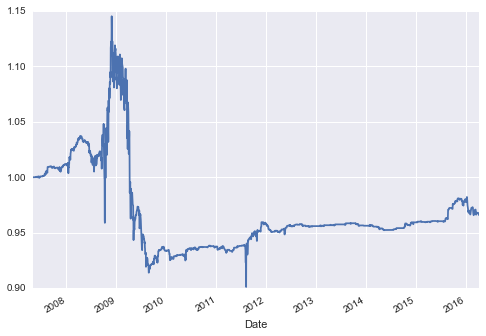

In [125]:
prices_get = True
symbolsDF = pd.read_pickle('../data/symbolsDF.pkl')
bigDF = pd.DataFrame()
if prices_get:
    priceDF = pd.DataFrame()
for symbol in symbolsDF.index[7::10]:
    if prices_get:
        priceDF[symbol] = get_prices(symbol)
    data = get_results(priceDF[symbol], 3.5, 160000)
    #data = entire_system(symbol, 3.5, 160000)
    bigDF[symbol] = data.returns
np.cumprod(bigDF.mean(axis=1)+1).plot()

In [126]:
filter_vr = get_vol_ratio_ROLL(priceDF, 5,8) > get_vol_ratio_ROLL(priceDF, 5,8).mean()

In [127]:
filtered_bigDF = bigDF * filter_vr

In [128]:
filtered_bigDF[filtered_bigDF == 0 ] = None

In [129]:
filtered_bigDF.mean(axis=1).sum()

-1.1212485234692582

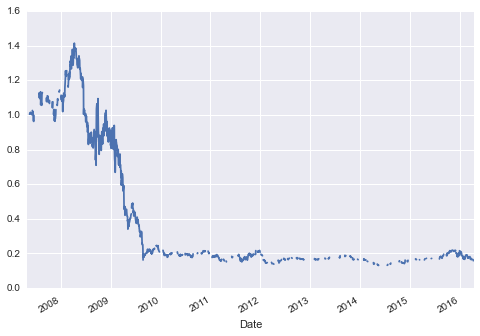

In [130]:
bigDF[bigDF == 0 ] = None
np.cumprod(bigDF.mean(axis=1)+1).plot()

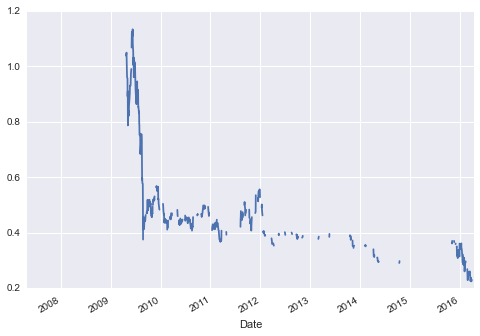

In [131]:
np.cumprod(filtered_bigDF.mean(axis=1)+1).plot()

In [345]:
filter_vr = get_vol_ratio(priceDF, 5,8) > get_vol_ratio(priceDF, 5,8).mean()

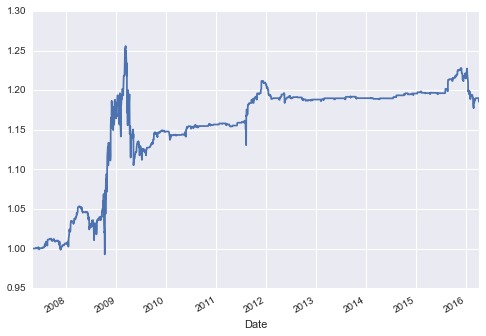

In [134]:
prices_get = False
symbolsDF = pd.read_pickle('../data/symbolsDF.pkl')
bigDF = pd.DataFrame()
if prices_get:
    priceDF = pd.DataFrame()
for symbol in symbolsDF.index[7::10]:
    if filter_vr[symbol] == False:
        continue
    if prices_get:
        priceDF[symbol] = get_prices(symbol)
    data = get_results(priceDF[symbol], 3.5, 160000)
    #data = entire_system(symbol, 3.5, 160000)
    bigDF[symbol] = data.returns
np.cumprod(bigDF.mean(axis=1)+1).plot()

In [135]:
bigDF[bigDF == 0 ] = None

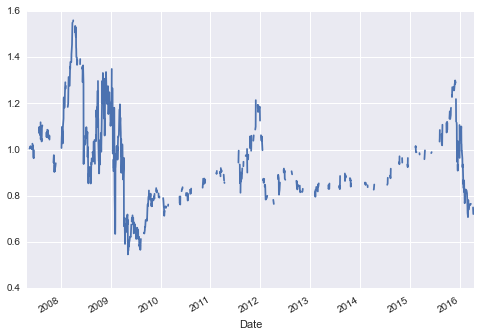

In [136]:
np.cumprod(bigDF.mean(axis=1)+1).plot()

In [356]:
get_vol_ratio(priceDF, 5,8)

BHI      1.015703
EOG      1.018499
MUR      1.010509
SWN      1.039528
ADS      1.030747
CSCO     1.027552
FIS      1.048086
KLAC     0.999886
NVDA     1.000803
SWKS     1.043494
XRX      1.004108
ED       0.999827
NI       1.048266
WEC      1.021323
EMN      1.013026
MOS      1.035413
ADM      1.015555
COST     1.047795
MKC      1.033967
SYY      1.020049
AIG      0.950378
BRK-B    1.082256
CME      1.052737
FITB     1.092723
JPM      1.074777
MHFI     1.034606
PFG      1.014810
STI      1.099031
WFC      1.066289
AGN      1.039713
BMY      0.999513
ENDP     0.995577
LLY      0.986747
DGX      1.011626
ANTM     0.997648
CHRW     1.021183
DNB      1.031503
GE       1.002672
LEG      1.018464
PWR      1.046471
TXT      0.957661
AAP      1.040361
CBS      0.982308
DLTR     1.029563
HBI      1.020519
LOW      1.025026
NKE      1.057913
SNI      1.035208
TWX      1.027542
VFC      1.056834
dtype: float64

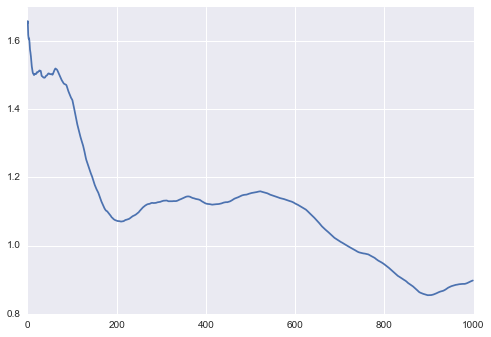

In [657]:
stds = []
for i in range(1, 1000):
    stds.append(np.std(priceDF['AAP']- priceDF['AAP'].shift(i)) * np.sqrt(1/i))
plot(stds)

In [658]:
kf=KalmanFilter(transition_matrices=[[1,1],[0,1]],observation_matrices=[[1,0]],
                initial_state_mean=[priceDF['AAP'][0],0],transition_covariance=[[.001,0],[0,.001]],
                observation_covariance=1) #TC -> Q ;; OC -> R
# kf=kf.em(prices,n_iter=5)
(a,b)=kf.filter(priceDF['AAP'])

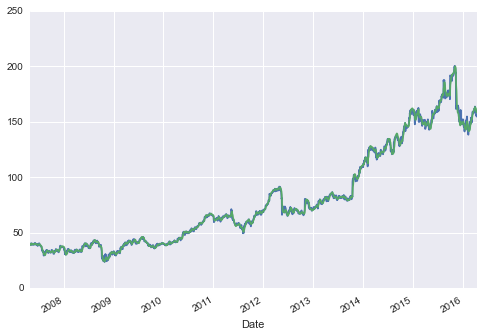

In [665]:
priceDF['AAP'].plot()
plot(priceDF.index, a[:,0])

In [674]:
data = priceDF.AAP.copy()
data = pd.DataFrame(data)
data['signal'] = data.AAP
data['filter'] = a[:,0]
data['resids'] = data.signal - data['filter']
data['position'] = 0
data.position[data.resids<-.5] = 1
data.position[data.resids>.5] = -1
data['daily_diff'] = data.signal.shift(-1) - data.signal
data['results'] = data.position * data.daily_diff

/Users/liamconnell/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/liamconnell/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


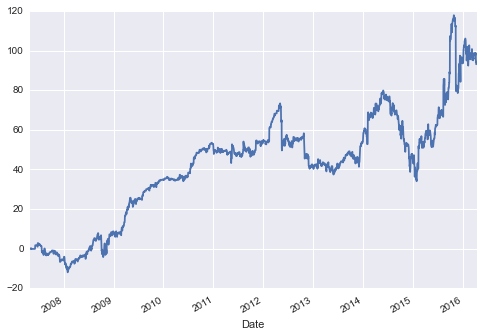

In [675]:
np.cumsum(data.results).plot()

In [390]:
abs(priceDF['STI'] - a[:,0]).mean()

0.49115298469210134

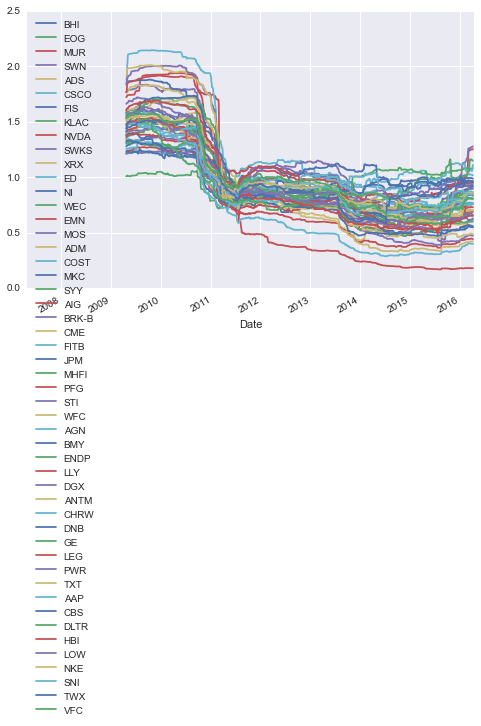

In [141]:
get_vol_ratio_ROLL(priceDF, 5,8).plot()

In [676]:
ts = []
for i in range(100000):
    ts.append(np.random.normal(scale=8))

In [677]:
ts = pd.DataFrame(np.cumsum(ts))

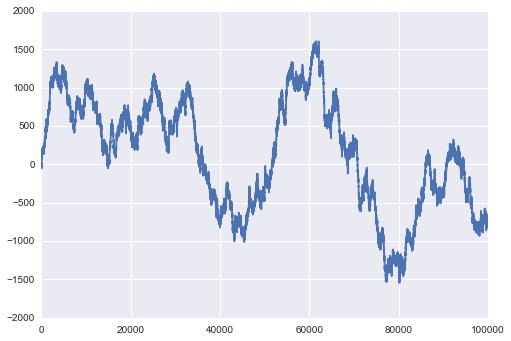

In [678]:
plot(ts)

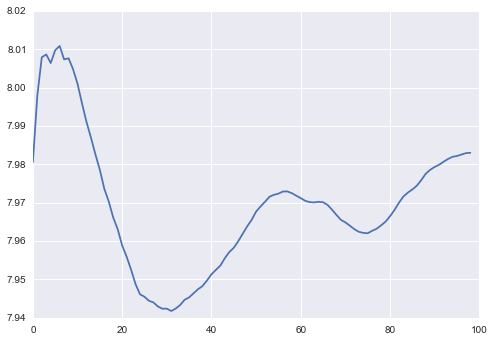

In [679]:
stds = []
for i in range(1, 100):
    stds.append(np.std(ts- ts.shift(i)) * np.sqrt(1/i))
plot(stds)

In [680]:
noise = []
for i in range(100000):
    noise.append(np.random.normal(scale = 100))
noise= pd.DataFrame(noise)

ts2 = ts + pd.DataFrame(noise)

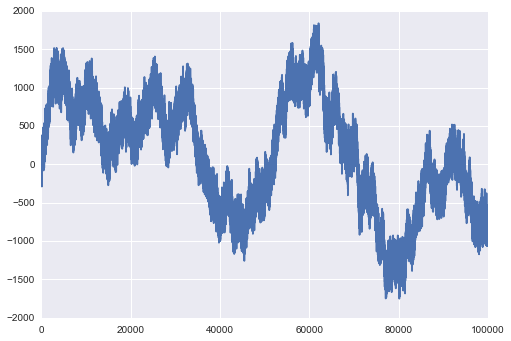

In [681]:
plot(ts2)

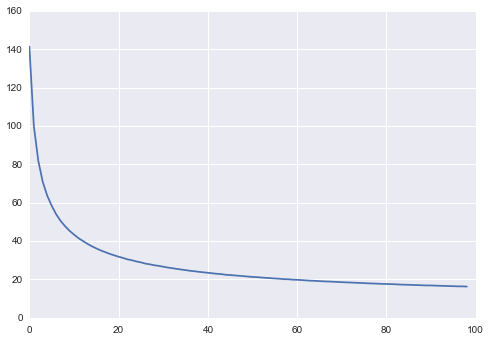

In [682]:
stds = []
for i in range(1, 100):
    stds.append(np.std(ts2- ts2.shift(i)) * np.sqrt(1/i))
plot(stds)

In [683]:
kf=KalmanFilter(transition_matrices=[[1,1],[0,1]],observation_matrices=[[1,0]],
                initial_state_mean=[0,0],transition_covariance=[[.001,0],[0,.001]],
                observation_covariance=1) #TC -> Q ;; OC -> R
# kf=kf.em(prices,n_iter=5)
(a,b)=kf.filter(ts2)

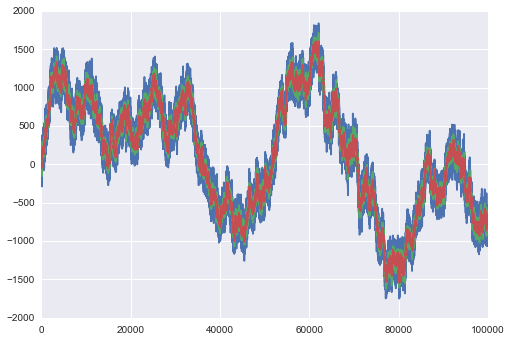

In [685]:
plot(ts2)
plot(a[:,0])
plot(ts)


In [654]:
test_data = pd.DataFrame(ts)
test_data.columns = ['random_walk']
test_data['noise'] = noise
test_data['signal'] = ts2
test_data['filter'] = a[:,0]
test_data['resids'] = test_data.signal - test_data['filter']
test_data['position'] = 0
test_data.position[test_data.resids<-1] = 1
test_data.position[test_data.resids>1] = -1
test_data['daily_diff'] = test_data.signal.shift(-1) - test_data.signal
test_data['results'] = test_data.position * test_data.daily_diff

/Users/liamconnell/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/liamconnell/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


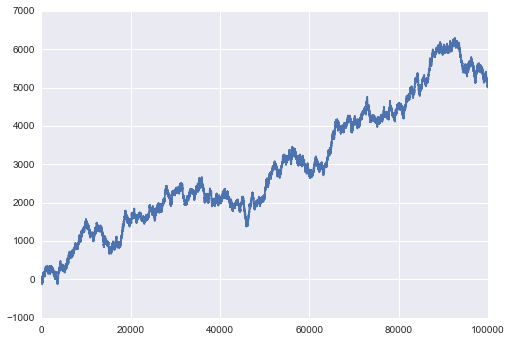

In [655]:
plot(np.cumsum(test_data.results))

In [497]:
test_data

,random_walk,noise,signal,filter,resids,position,daily_diff,results
0,-4.399295,-2.383764,-6.783059,-3.391529,-3.391529,0,-3.645757,-0.000000
1,3.959084,-14.387899,-10.428816,-7.615027,-2.813789,0,10.267893,0.000000
2,10.784689,-10.945611,-0.160922,-3.581273,3.420351,0,25.028463,0.000000
3,14.416527,10.451014,24.867541,14.173294,10.694247,-1,-13.179720,13.179720
4,11.238923,0.448898,11.687821,16.001752,-4.313931,0,-2.650443,-0.000000
5,17.350464,-8.313086,9.037378,15.430184,-6.392806,0,27.461866,0.000000
6,25.886519,10.612725,36.499244,26.867299,9.631945,0,-22.896678,-0.000000
7,15.302009,-1.699444,13.602566,24.991773,-11.389207,1,13.942980,13.942980
8,23.343809,4.201737,27.545546,28.575778,-1.030232,0,-28.315855,-0.000000
9,6.666311,-7.436621,-0.770309,21.457974,-22.228283,1,-10.055429,-10.055429


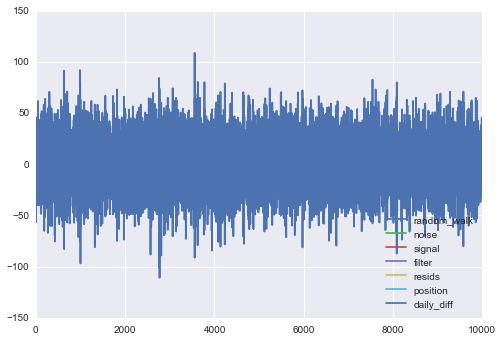

In [463]:
(ts - ts.shift(1)).plot()

In [191]:
ss = []
for i in range(100):
    ss.append(np.random.normal(.05))

In [193]:
ts = ts + pd.DataFrame(ss)